In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import os
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

colors = ["#ffffff","#66ff00","#66ff00","#66ff00","#66ff00","#66ff00","#99ff00","#99ff00","#99ff00","#99ff00","#99ff00",
          "#99ff00","#99ff00","#ccff00","#ccff00","#ccff00","#ccff00","#ffccff","#ffccff","#ff99ff","#ff99ff","#ff4cff",
          "#ff4cff","#ff4cff","#ff4cff","#ff4cff","#ff00ff","#ff00ff","#ff00ff"]
levels = [0,0.0001,1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,120,140,160,180,200,300,400,2000]

### Loading files to dataset

In [4]:
outdir='/work/jet/data/interim/'

# Odiv-255
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/'
# Odiv-233, 232, 231, 230
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/'
# Odiv-226, Odiv-210, Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/' # Odiv-183, Odiv-170

#subdir = 'CM4_historical_c192_OM4p125' # odiv-233/odiv-255
#subdir = 'CM4_ssp585_c192_OM4p25' # odiv-232
subdir = 'CM4_historical_c192_OM4p25' # Odiv-231
#subdir = 'CM4_piControl_c192_OM4p25_v8' # odiv-230
#subdir = 'CM4_piControl_c192_OM4p25_v7_npolefix' # Odiv-226
#subdir = 'CM4_piControl_c192_OM4p25_v7' # Odiv-210
#subdir = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt3' # Odiv-207
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt2' # Odiv-206
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200
#subdir = 'CM4_piControl_c192_OM4p125_v6' # Odiv-191
#subdir = 'CM4_piControl_c192_OM4p125_v5' # Odiv-184
#subdir = 'CM4_piControl_c192_OM4p125_v5_proto1' # Odiv-183
#subdir = 'CM4_piControl_c192_OM4p25' # Odiv-170

platform = 'gfdl.ncrc4-intel18-prod-openmp'
#platform = 'gfdl.ncrc5-intel22-prod-openmp' # odiv-255

In [5]:
tave = 'av' # ts, av
frq = 'monthly' # monthly, annual

# Inconsistent naming convention: ocean_month_z is used in p125 while ocean_monthly_z is used in p25
if subdir.split('_')[-1]=='p125':
    #pp_dirs = ['ice','ocean_%s'%frq, 'ocean_%s_z'%(frq[:-2] if frq=='monthly' else frq)]
    pp_dirs = ['ocean_%s'%frq,'ocean_%s_z'%(frq[:-2] if frq=='monthly' else frq)]
    #pp_dirs = ['ocean_%s_d2'%frq,'ocean_%s_z_d2'%frq] # d2
else:
    pp_dirs = ['ocean_%s'%frq,'ocean_%s_z'%frq]

In [6]:
ti,tf = '1950','1959'
tprd = '195*'

ddict = {pp:{} for pp in pp_dirs}
for pp in ddict:
    tres = '10yr' if frq=='annual' else '5yr'
    enddir = frq+'/'+tres+'/' if tave=='ts' else frq+'_'+tres+'/'
    full_path = os.path.join(rootdir,subdir,platform,'pp',pp)+'/'+tave+'/'+enddir
    print('dmls -lah',full_path+pp+'.%s.*.nc'%tprd)
    print('dmget',full_path+pp+'.%s.*.nc'%tprd,'&','\n')

dmls -lah /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.195*.*.nc
dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.195*.*.nc & 

dmls -lah /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/av/monthly_5yr/ocean_monthly_z.195*.*.nc
dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/av/monthly_5yr/ocean_monthly_z.195*.*.nc & 



In [7]:
ddict = {pp:{} for pp in pp_dirs}
for pp in ddict:
    tres = '10yr' if frq=='annual' else '5yr'
    enddir = frq+'/'+tres+'/' if tave=='ts' else frq+'_'+tres+'/'
    full_path = os.path.join(rootdir,subdir,platform,'pp',pp)+'/'+tave+'/'+enddir
    print('Loading files in\n',full_path)
    
    if tave =='ts':
        var = vars_ice if pp=='ice' else vars_srf if pp=='ocean_%s'%frq else vars_lev
        #var = vars_srf if pp=='ocean_%s'%frq else vars_lev
        for v in var:
            print(v)
            ddict[pp][v] = xr.open_mfdataset(full_path+pp+'.'+tprd+'.'+v+'.nc',use_cftime=True, chunks={'time': 1},
                                             drop_variables=['average_DT','average_T1','average_T2'])
            
    else:
        ddict[pp] = xr.open_mfdataset(full_path+'/'+pp+'.%s.*.nc'%tprd,use_cftime=True, 
                                      drop_variables=['average_DT','average_T1','average_T2'])

Loading files in
 /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/av/monthly_5yr/
Loading files in
 /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/av/monthly_5yr/


In [8]:
if tave =='ts':
    vars_srf_ds = xr.merge([ddict['ocean_%s'%frq][v] for v in ddict['ocean_%s'%frq]])
    vars_ds = xr.merge([ddict['ocean_%s_z'%(frq[:-2] if frq=='monthly' else frq)][v] \
                        for v in ddict['ocean_%s_z'%(frq[:-2] if frq=='monthly' else frq)]])
    #vars_ice_ds = xr.merge([ddict['ice'][v] for v in ddict['ice']])
    #vars_ds = xr.merge([vars_ds, vars_srf_ds, vars_ice_ds.rename({'xT':'xh','yT':'yh','xTe':'xq','yTe':'yq'})])
else:
    if subdir.split('_')[-1]=='p125':
        vars_ds = xr.merge([ddict[pp] if pp.split('_')[-1]=='z' else ddict[pp].drop_dims('zi') for pp in ddict])
    else:
        vars_ds = xr.merge([ddict[pp] if pp.split('_')[-1]=='z' else ddict[pp].drop_dims(['zl','zi']) for pp in ddict])

In [9]:
pp = 'ocean_monthly' # ocean_monthly, ocean_monthly_d2
print('Loading',os.path.join(rootdir,subdir,platform,'pp',pp)+'/'+pp+'.static.nc')
grid_ds = xr.open_dataset(os.path.join(rootdir,subdir,platform,'pp',pp)+'/'+pp+'.static.nc')

Loading /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ocean_monthly.static.nc


In [10]:
pd.concat([vars_ds.yh.to_series().reset_index(drop=True), vars_ds.yq.to_series().reset_index(drop=True),
           grid_ds.yh.to_series().reset_index(drop=True), grid_ds.yq.to_series().reset_index(drop=True)], axis=1)

,yh,yq,yh,yq
0,-80.389238,-80.429819,-80.389238,-80.429819
1,-80.308075,-80.348657,-80.308075,-80.348657
2,-80.226911,-80.267493,-80.226911,-80.267493
3,-80.145748,-80.186329,-80.145748,-80.186329
4,-80.064587,-80.105167,-80.064587,-80.105167
...,...,...,...,...
1076,89.621693,89.567649,89.621693,89.567649
1077,89.729781,89.675737,89.729781,89.675737
1078,89.837868,89.783825,89.837868,89.783825
1079,89.945956,89.891912,89.945956,89.891912


In [11]:
pd.concat([vars_ds.xh.to_series().reset_index(drop=True), vars_ds.xq.to_series().reset_index(drop=True),
           grid_ds.xh.to_series().reset_index(drop=True), grid_ds.xq.to_series().reset_index(drop=True)], axis=1)

,xh,xq,xh,xq
0,-299.724244,-299.842324,-299.724244,-299.842324
1,-299.476198,-299.594355,-299.476198,-299.594355
2,-299.228150,-299.346385,-299.228150,-299.346385
3,-298.980100,-299.098412,-298.980100,-299.098412
4,-298.732048,-298.850438,-298.732048,-298.850438
...,...,...,...,...
1436,59.283593,59.165825,59.283593,59.165825
1437,59.531631,59.413784,59.531631,59.413784
1438,59.779670,59.661746,59.779670,59.661746
1439,60.027712,59.909710,60.027712,59.909710


In [12]:
#grid_ds = grid_ds.assign_coords({'xh':vars_ds.xh,'yh':vars_ds.yh,'xq':vars_ds.xq,'yq':vars_ds.yq}) # p125_d2
grid_ds = grid_ds.isel(xq=slice(1,None),yq=slice(1,None)) # p25

vars_ds = vars_ds.isel(xq=slice(1,None),yq=slice(1,None)) # All
#grid_ds = grid_ds.isel(xq=slice(None,-1),yq=slice(None,-1)) # p125

## Potential vorticity

In [13]:
import momlevel as ml

In [14]:
n2 = ml.derived.calc_n2(vars_ds.thetao,vars_ds.so,zcoord='z_l').squeeze()

vars_ds['areacello_bu'] = xr.DataArray(grid_ds.areacello_bu.values,dims=('yq','xq'))
vars_ds['Coriolis'] = xr.DataArray(grid_ds.Coriolis.values,dims=('yq','xq'))
vars_ds['dxCu'] = xr.DataArray(grid_ds.dxCu.values,dims=('yh','xq'))
vars_ds['dyCv'] = xr.DataArray(grid_ds.dyCv.values,dims=('yq','xh'))

zeta = ml.derived.calc_rel_vort(vars_ds)
pv = ml.derived.calc_pv(zeta,vars_ds.Coriolis,n2).squeeze()

### Zonal means

In [15]:
def zonal_mean(da, metrics, weight, mask, xcoord):
    num = (da * metrics[weight] * metrics[mask]).sum(dim=[xcoord])
    denom = (da/da * metrics[weight] * metrics[mask]).sum(dim=[xcoord])
    return num/denom

In [16]:
lon = -140
dlon = 40
west, east, south, north = lon-dlon, lon+dlon, None, -30
reg = '%sEto%sW'%(str(abs(360+west)),str(abs(east))) if west<-180 else '%sWto%sW'%(str(abs(west)),str(abs(east)))
print('Average over %d to %d: %s'%(west, east,reg))

Average over -180 to -100: 180Wto100W


### Climatology (`av`)

In [17]:
with ProgressBar():
    pv_zm = zonal_mean(pv.sel(xq=slice(west,east)),grid_ds.sel(xq=slice(west,east)),'areacello_bu','wet_c','xq').load()
    
pv_zm.attrs = pv.attrs

[########################################] | 100% Completed |  1min 55.6s


In [23]:
fname = subdir+'_%sto%s_%s_av_pv_zonal_mean_%s.nc'\
        %(str(pv_zm.time.dt.year[0].values).rjust(4, '0'),str(pv_zm.time.dt.year[-1].values).rjust(4, '0'), frq, reg)
print('Saving to file:', fname)
#with ProgressBar():
pv_zm.reset_coords(drop=True).to_dataset(name='pv').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_historical_c192_OM4p25_1954to1959_monthly_av_pv_zonal_mean_180Wto100W.nc


### Monthly time series (`ts`)

In [19]:
pv_zm = zonal_mean(pv.sel(xq=slice(west,east)),grid_ds.sel(xq=slice(west,east)),'areacello_bu','wet_c','xq')
pv_zm.attrs = pv.attrs

In [24]:
with ProgressBar():
    da = pv_zm.isel(time=0).chunk({'yq':-1}).load()

[########################################] | 100% Completed | 49.8s


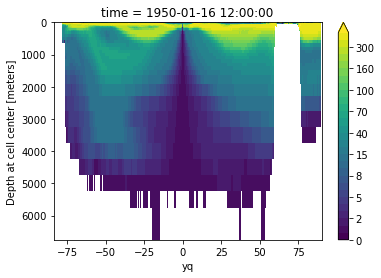

In [27]:
np.abs(((da/100)*1.e14)).plot(levels=[0,0.0001,1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,120,140,160,180,200,300,400,2000],
                                   vmin=0,vmax=2000,yincrease=False)

In [29]:
ds_pv = pv_zm.reset_coords(drop=True).to_dataset(name='pv')
t_str = '%sto%s'%(str(ds_pv.time.dt.year[0].values).rjust(4, '0'),str(ds_pv.time.dt.year[-1].values).rjust(4, '0'))

In [30]:
for tidx in range(0,len(ds_pv.time)):
    
    da = ds_pv.isel(time=tidx).pv.expand_dims({'time': 1})
    
    fname = subdir+'_%s_pv_zonal_mean_%s_%s_%s.nc'%(t_str, reg, frq, str(da.time.dt.strftime('%Y%m').values[0]))
    print('\n',tidx,da.time.dt.strftime('%Y-%m-%d').values[0])
    print('Saving to file:', fname)
    with ProgressBar():
        pv_zm_yr = da.load()
        
    pv_zm_yr.reset_coords(drop=True).to_dataset(name='pv').to_netcdf(outdir+fname, format='NETCDF4')


 0 1950-01-16
Saving to file: CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_monthly_195001.nc
[########################################] | 100% Completed | 49.4s

 1 1950-02-15
Saving to file: CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_monthly_195002.nc
[########################################] | 100% Completed | 49.3s

 2 1950-03-16
Saving to file: CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_monthly_195003.nc
[########################################] | 100% Completed | 45.7s

 3 1950-04-16
Saving to file: CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_monthly_195004.nc
[########################################] | 100% Completed | 52.5s

 4 1950-05-16
Saving to file: CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_monthly_195005.nc
[########################################] | 100% Completed | 52.4s

 5 1950-06-16
Saving to file: CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_

In [31]:
fnames = subdir+'_%s_pv_zonal_mean_%s_%s_*.nc'%(t_str, reg, frq)
print(fnames)

CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_monthly_*.nc


In [32]:
ds_pv = xr.open_mfdataset(outdir+fnames)

In [33]:
ds_pv

<xarray.Dataset>
Dimensions:  (time: 120, z_l: 35, yq: 2240)
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 1959-12-16 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * yq       (yq) float64 -83.6 -83.56 -83.52 -83.48 ... 89.84 89.89 89.95 90.0
Data variables:
    pv       (time, z_l, yq) float64 dask.array<chunksize=(1, 35, 2240), meta=np.ndarray>

In [34]:
fname = subdir+'_%s_pv_zonal_mean_%s_%s.nc'%(t_str, reg, frq)
print('Saving to file:', fname)
ds_pv.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_monthly.nc


### Check output

In [24]:
pv_mean = xr.open_dataset(outdir+fname).pv.sel(time=slice(ti,tf)).mean('time')

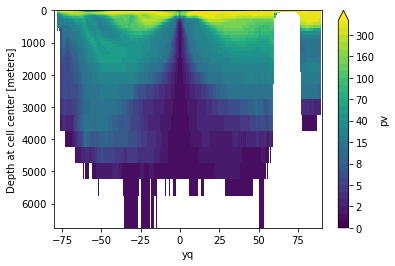

In [25]:
np.abs(((pv_mean/100)*1.e14)).plot(levels=[0,0.0001,1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,120,140,160,180,200,300,400,2000],
                                   vmin=0,vmax=2000,yincrease=False)

### Comparison of PV sections from climatology (`av`) versus monthly (`ts`) data

In [37]:
# Make sure to use the same time period
ti,tf = '1950','1959'

ddict_pv = {tave:{} for tave in ['av','ts']}

fname_av = 'CM4_historical_c192_OM4p125_1954to1959_monthly_av_pv_zonal_mean_180Wto100W.nc'
ddict_pv['av'] = xr.open_dataset(outdir+fname_av).pv.sel(time=slice(ti,tf)).mean('time')

fname_ts = 'CM4_historical_c192_OM4p125_1950to1959_pv_zonal_mean_180Wto100W_monthly.nc'
ddict_pv['ts'] = xr.open_dataset(outdir+fname_ts).pv.sel(time=slice(ti,tf)).mean('time')

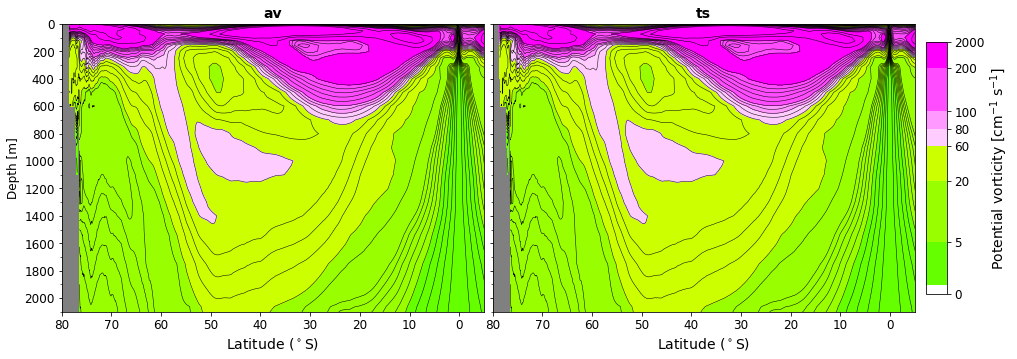

In [44]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,5))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, wspace=0.02)

for i, tave in enumerate(ddict_pv):
    pv = ddict_pv[tave]
    X = np.abs(((pv/100)*1.e14))
    
    p = axs[i].contourf(X.yq, X.z_l, X.values, levels=levels, colors=colors, extend='neither')
    axs[i].contour(X.yq, X.z_l, X.values, levels=levels, colors=['k'], linewidths=[0.5])
    axs[i].set_ylim(2100, 0)
    axs[i].yaxis.set_major_locator(MultipleLocator(200))
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[i].yaxis.set_minor_locator(MultipleLocator(100))

    if i==0:
        axs[i].set_ylabel('Depth [m]',fontsize=12)
        
    axs[i].set_xlim(-80,5)
    axs[i].set_xticks(np.arange(-80,10,10))
    axs[i].set_xticklabels(np.arange(80,-10,-10))
    axs[i].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
    axs[i].tick_params(axis='both', which='both', labelsize=12)
    axs[i].set_facecolor('gray')
    axs[i].set_title(tave, fontsize=14, fontweight='bold')

cax = fig.add_axes([0.9, 0.15, 0.02, 0.70])
cb = fig.colorbar(p, cax=cax, ticks=[0,5,20,60,80,100,200,2000], orientation='vertical', shrink=0.9, pad=0.03)
cb.set_label('Potential vorticity [cm$^{-1}$ s$^{-1}$]',fontsize=14)
cb.ax.tick_params(labelsize=12)

#plt.savefig('/work/jet/figure.png', dpi=300, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Potential density

In [26]:
sigma0 = ml.derived.calc_pdens(vars_ds.thetao,vars_ds.so,level=0.0)
sigma0_zm = zonal_mean(sigma0.sel(xh=slice(-180,-100)),grid_ds.sel(xh=slice(-180,-100)),'areacello','wet','xh')
sigma0_zm.attrs = sigma0.attrs

In [27]:
fname = subdir+'_%sto%s_%s_av_pdens_sigma0_zonal_mean_%s.nc'\
        %(str(sigma0_zm.time.dt.year[0].values).rjust(4, '0'),str(sigma0_zm.time.dt.year[-1].values).rjust(4, '0'), frq, reg)
print('Saving to file:', fname)
with ProgressBar():
    sigma0_zm.reset_coords(drop=True).to_dataset(name='sigma0').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_historical_c192_OM4p25_1954to1959_monthly_av_pdens_sigma0_zonal_mean_180Wto100W.nc
[########################################] | 100% Completed | 40.1s


In [28]:
sig0_mean = xr.open_dataset(outdir+fname).sigma0.sel(time=slice(ti,tf)).mean('time')

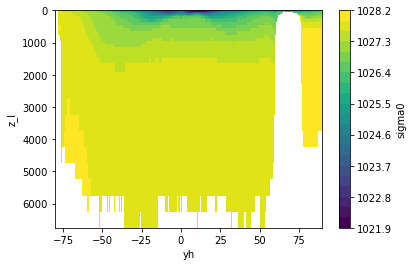

In [29]:
sig0_mean.plot(levels=22,yincrease=False)

## Salinity

In [30]:
so_zm = zonal_mean(vars_ds.so.sel(xh=slice(-180,-100)),grid_ds.sel(xh=slice(-180,-100)),'areacello','wet','xh')
so_zm.attrs = {k: v for k, v in vars_ds.so.attrs.items() if k in ['long_name','units']}

In [31]:
fname = subdir+'_%sto%s_%s_av_so_zonal_mean_%s.nc'\
        %(str(so_zm.time.dt.year[0].values).rjust(4, '0'),str(so_zm.time.dt.year[-1].values).rjust(4, '0'),frq, reg)
print('Saving to file:', fname)
with ProgressBar():
    so_zm.reset_coords(drop=True).to_dataset(name='so').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_historical_c192_OM4p25_1954to1959_monthly_av_so_zonal_mean_180Wto100W.nc
[########################################] | 100% Completed |  7.8s


In [32]:
so_mean = xr.open_dataset(outdir+fname).so.sel(time=slice(ti,tf)).mean('time')

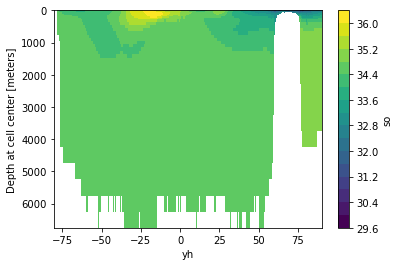

In [33]:
so_mean.plot(levels=22,yincrease=False)

# Potential vorticity

Using **equation (9)** in [Cerovecki et al. (2013)](https://doi.org/10.1175/JPO-D-12-0121.1):
$$ PV = \frac{f}{\rho_{\theta}} \frac{\partial\rho_{\theta}}{\partial z} $$
where $f$ is the Coriolis parameter and $\rho_{\theta}$ is the potential density.

### Build an xgcm grid object

In [34]:
from xgcm import Grid

In [35]:
grid_ds['z_l'] = vars_ds['z_l']
grid_ds['z_i'] = vars_ds['z_i']
grid_ds['dzt'] = grid_ds['z_l'].copy(data=grid_ds['z_i'].diff('z_i'))

# Replace all in NaNs with zeros
grid_ds['dxt'] = grid_ds['dxt'].fillna(0.)
grid_ds['dyt'] = grid_ds['dyt'].fillna(0.)
grid_ds['dzt'] = grid_ds['dzt'].fillna(0.)
grid_ds['areacello'] = grid_ds['areacello'].fillna(0.)
grid_ds['volcello'] = vars_ds['volcello'].fillna(0.)

metrics = {('X',): ['dxt','dxCu','dxCv'], # X distances
           ('Y',): ['dyt','dyCu','dyCv'], # Y distances
           ('Z',): ['dzt'], # Z distances
           ('X', 'Y'): ['areacello'], # Areas
           ('X', 'Y', 'Z'): ['volcello'], # Volumes
          }

xgrid = Grid(grid_ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                              'Y': {'center': 'yh', 'right': 'yq'},
                              'Z': {'center': 'z_l', 'outer': 'z_i'}}, metrics=metrics, periodic=['X'])

### Calculation

In [36]:
import fastjmd95 as jmd95

In [37]:
rho0 = 1035.0
vars_ds['rho0'] = jmd95.rho(vars_ds.so, vars_ds.thetao, 0)

In [38]:
# Interpolare rho to outer (zi)
rho0_i = xgrid.interp(vars_ds.rho0, 'Z', boundary='extend')

# Calculate difference
drho = xgrid.diff(rho0_i,'Z')

# Calculate derivative (drho/dz)
drhodz = xgrid.derivative(rho0_i,'Z')

In [39]:
# Interpolate Coriolis to center grid
fq = xgrid.interp(grid_ds.Coriolis, 'X', boundary='fill')
f = xgrid.interp(fq, 'Y', boundary='fill')

In [40]:
vars_ds['pv'] = (-f/rho0*drhodz).transpose('time','z_l','yh','xh')

### Regional section

In [41]:
from wmt_inert_tracer.swmt import swmt
from wmt_inert_tracer.preprocessing import preprocessing
from wmt_inert_tracer.compute import lbin_define, zonal_mean

In [42]:
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import hovmoeller, cartopy_map, cartopy_map_so

In [43]:
ds = preprocessing(vars_ds, grid_ds, decode_times=False, verbose=False)

In [44]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

1954-01-16 to 1959-12-16


In [45]:
lon = -140
dlon = 40
west, east, south, north = lon-dlon, lon+dlon, None, -30

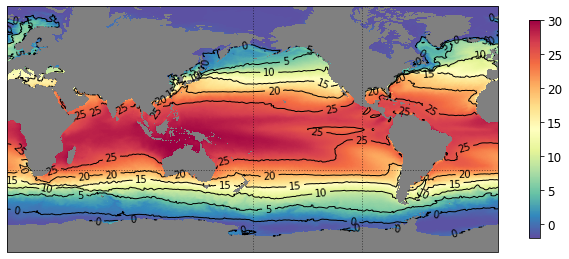

In [46]:
fig = cartopy_map(ds.isel(lev=0,time=0),'thetao', varc='thetao', cmap='Spectral_r', vrange=[-2,30], drawBath=False,
                  central_longitude=180, fsize=[11,5], drawGrid=True, parallels=[north],meridians=[west,east],
                  clfmt='%1.0f', clevels=np.arange(0,30,5), clf=10, clw=1, ccol='k')

In [47]:
ds_reg = ds.sel(x=slice(west,east),y=slice(south,north)).drop_dims(['xq','yq'])

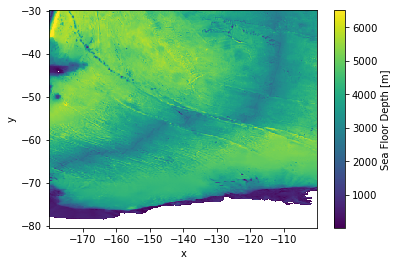

In [48]:
ds_reg.deptho.plot()

In [49]:
ds_reg['sigma0'] = jmd95.rho(ds_reg.so, ds_reg.thetao, 0) - 1000

In [50]:
with ProgressBar():
    ds_reg_mean = ds_reg[['thetao','so','sigma0','pv']].sel(time=slice(ti,tf)).mean('time').load()

[########################################] | 100% Completed | 39.9s


In [51]:
ds_reg_mean = xr.merge([ds_reg_mean, ds_reg[['deptho','areacello','wet']]])

In [52]:
reg = 'SouthPacific_%sEto%sW'%(str(abs(360+west)),str(abs(east))) if west<-180 else 'SouthPacific_%sWto%sW'%(str(abs(west)),str(abs(east)))
fname = subdir+'_so_%sto%s_southof%sS_%s_annual_means.nc'\
        %(str(ds_reg.time.dt.year[0].values).rjust(4, '0'),
          str(ds_reg.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''), reg)
print('Saving to file:', fname)
ds_reg_mean.to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_historical_c192_OM4p25_so_1954to1959_southof30S_SouthPacific_180Wto100W_annual_means.nc


In [53]:
from plot import zm_section
import cmocean.cm as cmo

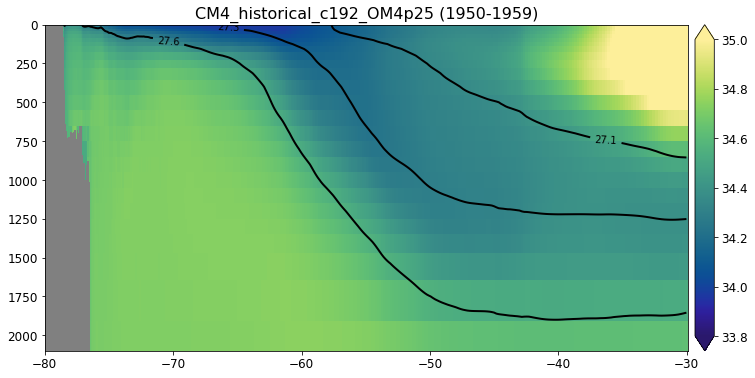

In [54]:
fig, ax = zm_section(ds_reg_mean,'so',varc='sigma0', cmap=cmo.haline,vrange=[33.8,35],ylimrange=[2100, 0],
                     xlimrange=[-80,None], fsize=(12,6),clevels=[27.6,27.3,27.1],clf=10,
                     clfmt='%1.1f',ccol='k',title=subdir+' (%s-%s)'%(ti,tf))

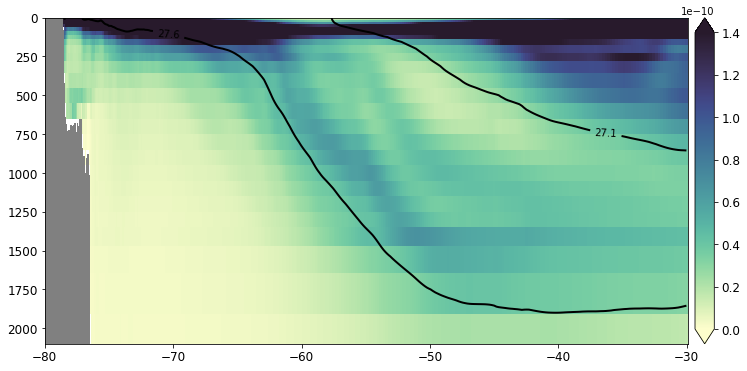

In [55]:
fig, ax = zm_section(ds_reg_mean,'pv',varc='sigma0', cmap=cmo.deep,vrange=[0,14e-11],ylimrange=[2100, 0],xlimrange=[-80,None], fsize=(12,6),
                     clevels=[27.6,27.1],clf=10,clfmt='%1.1f',ccol='k')

### Comparison of PV sections between the two calculation methods

In [114]:
from wmt_inert_tracer.compute import zonal_mean

In [56]:
# Make sure to use the same time period
print(ti,tf)
#ti,tf = '1950','1959'

ddict_pv = {name:{} for name in ['v1','v2']}

fname_pv = subdir+'_1954to1959_monthly_av_pv_zonal_mean_180Wto100W.nc'
ddict_pv['v1']['pv'] = xr.open_dataset(outdir+fname_pv).pv.sel(time=slice(ti,tf)).mean('time')

fname_sig = subdir+'_1954to1959_monthly_av_pdens_sigma0_zonal_mean_180Wto100W.nc'
ddict_pv['v1']['sig'] = xr.open_dataset(outdir+fname_sig).sigma0.sel(time=slice(ti,tf)).mean('time')

# Same as v1
#ddict_pv['v2']['pv'] = pv_mean
#ddict_pv['v2']['sig'] = sigma0_zm

ddict_pv['v2']['pv'] = zonal_mean(ds_reg_mean.pv,ds_reg_mean)
ddict_pv['v2']['sig'] = zonal_mean(ds_reg_mean.sigma0,ds_reg_mean)

1950 1959


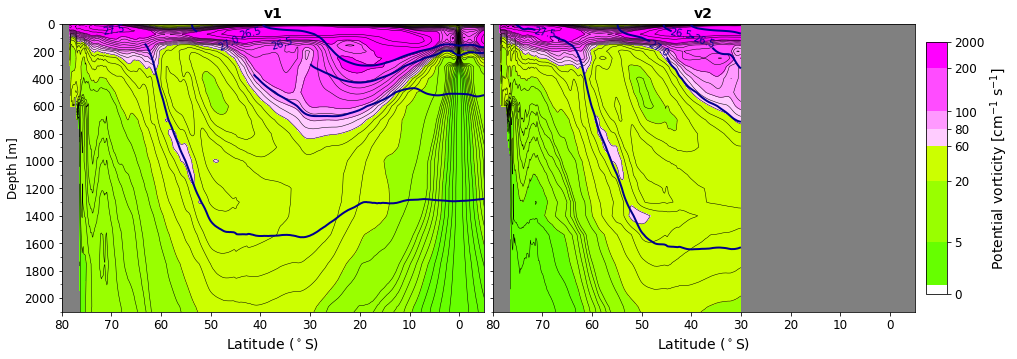

In [59]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,5))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, wspace=0.02)

for i, method in enumerate(ddict_pv):
    da = ddict_pv[method]['pv']
    X = np.abs(((da/100)*1.e14))
    
    ydim = 'yq' if method=='v1' else 'y'
    zdim = 'z_l' if method=='v1' else 'lev'
    p = axs[i].contourf(X[ydim], X[zdim], X.values, levels=levels, colors=colors, extend='neither')
    axs[i].contour(X[ydim], X[zdim], X.values, levels=levels, colors=['k'], linewidths=[0.5])
    
    sig = ddict_pv[method]['sig']-1000 if method=='v1' else ddict_pv[method]['sig']
    ydim = 'yh' if method=='v1' else 'y'
    cs0 = axs[i].contour(sig[ydim], sig[zdim], sig.values, levels=[26.0,26.5,27.0,27.5], colors='darkblue', linewidths=2)
    axs[i].clabel(cs0, cs0.levels, inline=True, fmt='%1.1f', fontsize=10, manual=[(-42,50),(-38,200),(-50,550),(-70,250)])
    
    axs[i].set_ylim(2100, 0)
    axs[i].yaxis.set_major_locator(MultipleLocator(200))
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[i].yaxis.set_minor_locator(MultipleLocator(100))

    if i==0:
        axs[i].set_ylabel('Depth [m]',fontsize=12)
        
    axs[i].set_xlim(-80,5)
    axs[i].set_xticks(np.arange(-80,10,10))
    axs[i].set_xticklabels(np.arange(80,-10,-10))
    axs[i].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
    axs[i].tick_params(axis='both', which='both', labelsize=12)
    axs[i].set_facecolor('gray')
    axs[i].set_title(method, fontsize=14, fontweight='bold')

cax = fig.add_axes([0.9, 0.15, 0.02, 0.70])
cb = fig.colorbar(p, cax=cax, ticks=[0,5,20,60,80,100,200,2000], orientation='vertical', shrink=0.9, pad=0.03)
cb.set_label('Potential vorticity [cm$^{-1}$ s$^{-1}$]',fontsize=14)
cb.ax.tick_params(labelsize=12)

#plt.savefig('/work/jet/figure.png', dpi=300, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

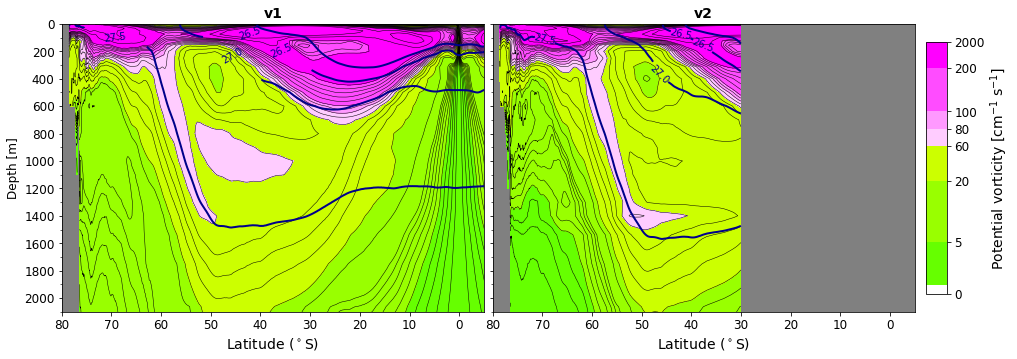

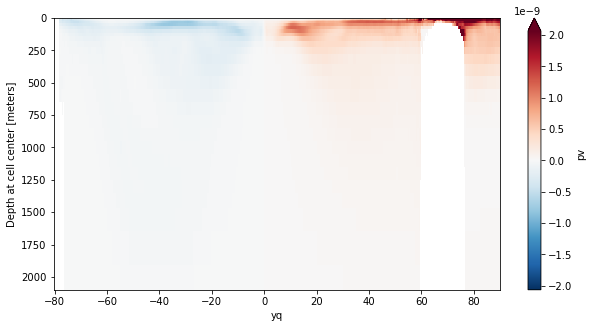

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
ddict_pv['v1']['pv'].plot(ax=ax,yincrease=False,robust=True)
ax.set_ylim(2100, 0)
plt.show()

### Cross sections

In [61]:
def zonal_mean(da, metrics, weight, mask, xcoord):
    num = (da * metrics[weight] * metrics[mask]).sum(dim=[xcoord])
    denom = (da/da * metrics[weight] * metrics[mask]).sum(dim=[xcoord])
    return num/denom

In [64]:
with ProgressBar():
    #pv_mean = pv.sel(xq=slice(-180,-100)).mean('xq').sel(time=slice(ti,tf)).mean('time').load()
    pv_mean = zonal_mean(pv.sel(xq=slice(-180,-100)),grid_ds.sel(xq=slice(-180,-100)),
                         'areacello_bu','wet_c','xq').sel(time=slice(ti,tf)).mean('time').load()

[########################################] | 100% Completed |  1min 45.9s


In [65]:
sigma0 = ml.derived.calc_pdens(vars_ds.thetao,vars_ds.so,level=0.0)
sigma1 = ml.derived.calc_pdens(vars_ds.thetao,vars_ds.so,level=1000.0)
sigma2 = ml.derived.calc_pdens(vars_ds.thetao,vars_ds.so,level=2000.0)
sigma4 = ml.derived.calc_pdens(vars_ds.thetao,vars_ds.so,level=4000.0)

In [66]:
with ProgressBar():
    sigma0_zm = zonal_mean(sigma0.sel(xh=slice(-180,-100)),grid_ds.sel(xh=slice(-180,-100)),
                           'areacello','wet','xh').sel(time=slice(ti,tf)).mean('time').load()

[########################################] | 100% Completed | 40.1s


In [67]:
X = np.abs(((pv_mean/100)*1.e14))
zcoord = 'z_l'

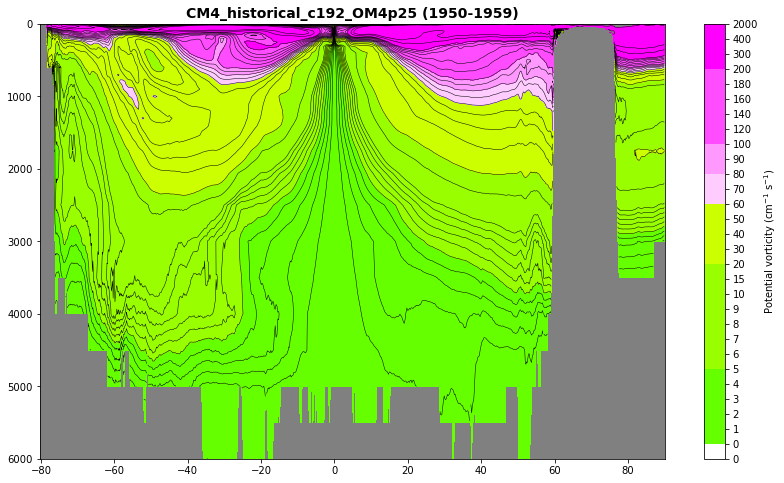

In [68]:
figure = plt.figure(figsize=(14,8))
ax = plt.subplot(1,1,1,facecolor="gray")
cs = ax.contourf(X.yq, X[zcoord], X.values, levels=levels, colors=colors, extend="neither")
ax.contour(X.yq, X[zcoord], X.values, levels=levels, colors=["k"], linewidths=[0.5])

# McCarthy and Talley blue isopycnals
#cs0 = ax.contour(sigma0_zm.yh, sigma0_zm.z_l, sigma0_zm.values-1000, levels=[26.0,26.5,27.0,27.5], colors='darkblue', linewidths=2)
#ax.clabel(cs0, cs0.levels, inline=True, fmt='%1.1f', fontsize=10)#, manual=cloc)
#ax.contour(sigma1.yh, sigma1.z_l, sigma1.values, levels=[1031.7], colors=["b"],linewidths=[4])
#ax.contour(sigma2.yh, sigma2.z_l, sigma2.values, levels=[1036.96], colors=["b"],linewidths=[4])
#ax.contour(sigma4.yh, sigma4.z_l, sigma4.values, levels=[1045.88], colors=["b"],linewidths=[4])

cbar = plt.colorbar(cs, ticks=levels)
cbar.set_label('Potential vorticity (cm$^{-1}$ s$^{-1}$)')
ax.set_ylim(6000,0)
ax.set_title(subdir+' (%s-%s)'%(ti,tf), fontsize=14, fontweight='bold')

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

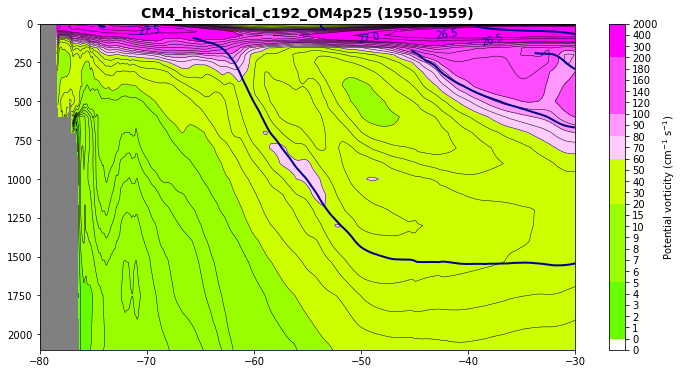

In [69]:
figure = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1,facecolor="gray")
cs = ax.contourf(X.yq, X[zcoord], X.values, levels=levels, colors=colors, extend="neither")
ax.contour(X.yq, X[zcoord], X.values, levels=levels, colors=["k"], linewidths=[0.5])

cs0 = ax.contour(sigma0_zm.yh, sigma0_zm.z_l, sigma0_zm.values-1000, levels=[26.0,26.5,27.0,27.5], 
                 colors='darkblue', linewidths=2)
ax.clabel(cs0, cs0.levels, inline=True, fmt='%1.1f', fontsize=10, manual=[(-42,50),(-38,200),(-50,550),(-70,250)])
# McCarthy and Talley blue isopycnals
#ax.contour(sigma0.yh,sigma0.z_l,sigma0.values,levels=[1025.2,1026.0,1026.8],colors=["b"],linewidths=[4])
#ax.contour(sigma1.yh,sigma1.z_l,sigma1.values,levels=[1031.7],colors=["b"],linewidths=[4])
#ax.contour(sigma2.yh,sigma2.z_l,sigma2.values,levels=[1036.96],colors=["b"],linewidths=[4])
#ax.contour(sigma4.yh,sigma4.z_l,sigma4.values,levels=[1045.88],colors=["b"],linewidths=[4])

cbar = plt.colorbar(cs, ticks=levels)
cbar.set_label('Potential vorticity (cm$^{-1}$ s$^{-1}$)')
ax.set_ylim(2100, 0)
ax.set_xlim(-80,-30)
ax.set_title(subdir+' (%s-%s)'%(ti,tf), fontsize=14, fontweight='bold')

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [70]:
X = np.abs(((ds_reg_mean.pv.mean('x')/100)*1.e14))

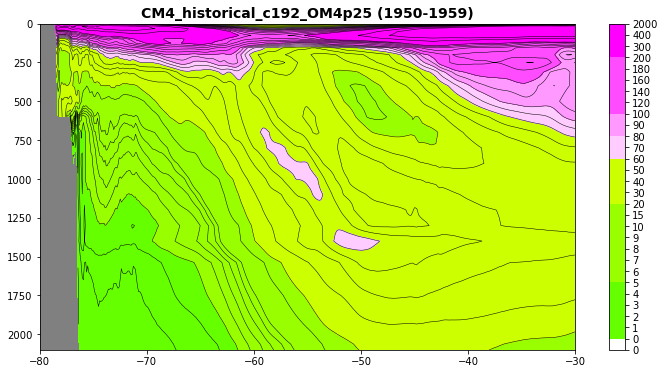

In [71]:
figure = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1,facecolor="gray")
cs = ax.contourf(X.y, X.lev, X.values, levels=levels, colors=colors, extend="neither")
ax.contour(X.y, X.lev, X.values, levels=levels, colors=["k"], linewidths=[0.5])
plt.colorbar(cs, ticks=levels)
ax.set_ylim(2100, 0)
ax.set_xlim(-80,-30)
ax.set_title(subdir+' (%s-%s)'%(ti,tf), fontsize=14, fontweight='bold')
plt.show()

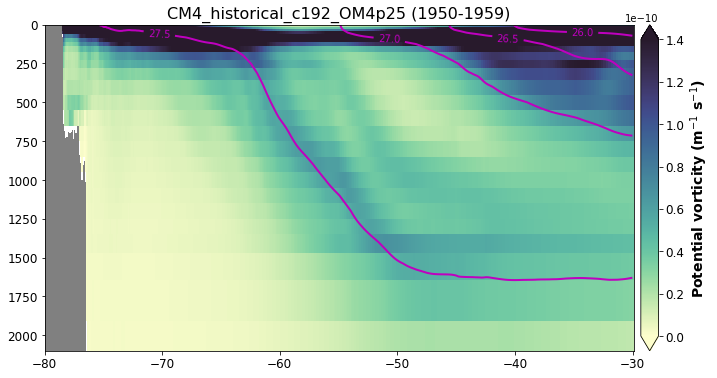

In [72]:
fig, ax = zm_section(ds_reg_mean,'pv',varc='sigma0', cmap=cmo.deep,vrange=[0,14e-11],ylimrange=[2100, 0],
                     xlimrange=[-80,None], fsize=(11,6),clevels=[26.0,26.5,27.0,27.5],clf=10,
                     clfmt='%1.1f',ccol='m',title=subdir+' (%s-%s)'%(ti,tf),cb_label='Potential vorticity (m$^{-1}$ s$^{-1}$)')

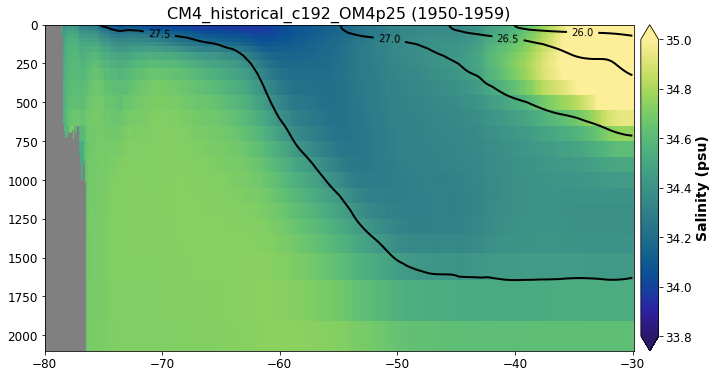

In [73]:
fig, ax = zm_section(ds_reg_mean,'so',varc='sigma0', cmap=cmo.haline,vrange=[33.8,35],ylimrange=[2100, 0],
                     xlimrange=[-80,None], fsize=(11,6),clevels=[26.0,26.5,27.0,27.5],clf=10,
                     clfmt='%1.1f',ccol='k',title=subdir+' (%s-%s)'%(ti,tf),cb_label='Salinity (psu)')